# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [100]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)

In [10]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [11]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [12]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))
pnl['Unrealized PnL']=pnl['Price in USDT']-pnl['Book Cost']
pnl=pnl.fillna(0)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.round(4).sort_values(by='Total PnL')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.9350,2033.4643,1.0000,-131.8862,-151.4708,-283.3570
JASMYUSDT,387.4585,242.5534,0.1193,0.0000,-144.9051,-144.9051
ETHUSDT,250.7473,170.9418,0.0841,0.0000,-79.8055,-79.8055
BBUSDT,60.1761,36.6116,0.0180,-39.7331,-23.5644,-63.2975
BTCUSDT,601.0216,556.2715,0.2736,3.5371,-44.7501,-41.2130
PEPEUSDT,0.0000,0.0000,0.0000,-38.5220,-0.0000,-38.5220
SOLUSDT,281.2005,263.9471,0.1298,0.0000,-17.2534,-17.2534
BNBUSDT,1.1421,0.9733,0.0005,-10.6060,-0.1688,-10.7749
NEARUSDT,0.0000,0.0000,0.0000,-10.3396,0.0000,-10.3396
TRXUSDT,76.8690,78.8756,0.0388,-10.7239,2.0067,-8.7172


In [13]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [14]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [15]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [16]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [17]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [18]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

In [20]:
positions=positions.sort_index()

In [21]:
positions.index=pd.to_datetime(positions.index)

In [22]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [23]:
positions.to_excel('Positions.xlsx')
quantities.to_excel('Quantities.xlsx')

In [24]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [25]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [26]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [27]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [28]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [29]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [30]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

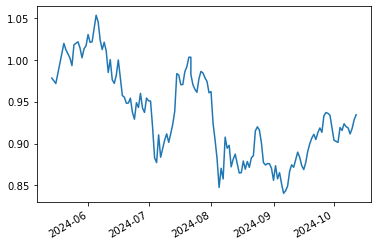

In [31]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [32]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [33]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [34]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT',
       'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT', 'ORDIUSDT',
       'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT',
       'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT',
       'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT', 'XLMUSDT',
       'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [35]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit_hist[3]]-0.001}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9301
OMUSDT,0.0247
TRXUSDT,0.0214
BNBUSDT,0.0156
PEPEUSDT,0.0048
SUIUSDT,0.0033
GALAUSDT,0.0000
WLDUSDT,0.0000
CFXUSDT,0.0000
ATOMUSDT,0.0000


In [37]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.491604
BTCUSDT,0.400000
PEPEUSDT,0.062266
SUIUSDT,0.046130


In [38]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [39]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.726339
OMUSDT,0.273661


## Real Portfolio vs Optimal

In [40]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,683.289813,0.336023,0.273661,0.062362
BTCUSDT,556.271523,0.273558,0.000000,0.000000
SOLUSDT,263.947122,0.129802,0.000000,0.000000
JASMYUSDT,242.553418,0.119281,0.000000,0.000000
ETHUSDT,170.941837,0.084064,0.000000,0.000000
TRXUSDT,78.875607,0.038789,0.726339,-0.687550
BBUSDT,36.611635,0.018005,0.000000,0.000000
BNBUSDT,0.973302,0.000479,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [41]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,683.289813,0.336023,0.491604,-0.155581
BTCUSDT,556.271523,0.273558,0.400000,-0.126441
SOLUSDT,263.947122,0.129802,0.000000,0.000000
JASMYUSDT,242.553418,0.119281,0.000000,0.000000
ETHUSDT,170.941837,0.084064,0.000000,0.000000
TRXUSDT,78.875607,0.038789,0.000000,0.000000
BBUSDT,36.611635,0.018005,0.000000,0.000000
BNBUSDT,0.973302,0.000479,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.062266,-0.062266
SUIUSDT,0.000000,0.000000,0.046130,0.000000


# Risk Reward Analysis

In [42]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [43]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

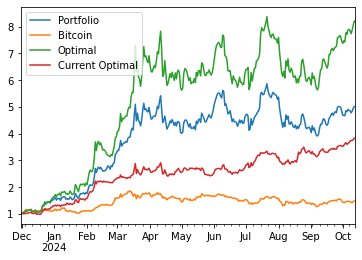

In [44]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [45]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

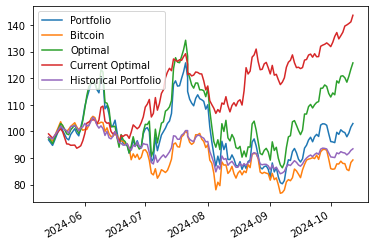

In [46]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [47]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-10-03,95.759189,85.894047,113.745024,135.693259,90.135937
2024-10-04,99.637798,87.758707,118.974917,137.143317,91.907783
2024-10-05,98.866619,87.719120,118.150282,134.758131,91.567253
2024-10-06,100.588465,88.789524,120.733547,135.953470,92.355012
2024-10-07,99.878831,87.943245,120.899476,137.247795,92.014237
2024-10-08,99.528562,87.853439,120.146319,139.587459,91.863073
2024-10-09,97.967358,85.671996,118.483493,140.009395,91.148267
2024-10-10,99.375334,85.233402,120.716763,140.539791,91.791854
2024-10-11,101.616263,88.304932,123.408872,141.164518,92.829657
2024-10-12,102.936429,89.240643,125.731335,143.636797,93.432469


## Volatilities

In [48]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.727591
dtype: float64

In [49]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.535218
dtype: float64

In [50]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.617860
Bitcoin            0.436294
Optimal            0.728706
Current Optimal    0.425864
dtype: float64

In [51]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.20299770237818757

## Risk Contribution

In [52]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.191360,0.400000,0.044705,0.149498,0.057355,0.092142
OMUSDT,11.835665,0.491604,0.931894,0.781353,0.687618,0.093735
PEPEUSDT,0.146740,0.062266,0.015800,0.048905,0.011838,0.037067
SUIUSDT,0.054428,0.046130,0.007602,0.020245,0.003666,0.016579


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.191791,0.273661,0.337068,0.518054,0.456879,0.061175
TRXUSDT,0.189093,0.726339,0.662932,0.481946,0.420771,0.061175


In [54]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.238284,0.34,0.496703,0.440238,0.270245,0.169993
BTCUSDT,-0.013265,0.27,0.220516,0.169580,0.041669,0.127911
SOLUSDT,-0.015658,0.13,0.098211,0.127040,0.025020,0.102020
JASMYUSDT,-0.025002,0.12,0.081596,0.163758,0.045107,0.118652
ETHUSDT,-0.018540,0.08,0.052790,0.060515,0.006309,0.054206
TRXUSDT,0.010413,0.04,0.043301,0.005984,0.000489,0.005495
BBUSDT,-0.011987,0.02,0.006882,0.032886,0.002646,0.030240


# Value At Risk

## Historical

In [55]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.060605701185728444, -0.08666319821393602)

In [56]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.047862431307500425, -0.06882668957751599)

In [57]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [58]:
var=historical_var.iloc[row]
var

OMUSDT       0.013592
BTCUSDT     -0.019948
SOLUSDT     -0.008294
JASMYUSDT   -0.019867
ETHUSDT     -0.008443
TRXUSDT     -0.001581
BBUSDT      -0.002569
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.047112
Name: 2024-08-05 00:00:00, dtype: float64

In [59]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.026084
BTCUSDT     -0.012342
SOLUSDT     -0.009383
JASMYUSDT   -0.011123
ETHUSDT     -0.004940
TRXUSDT     -0.000669
BBUSDT      -0.001873
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.066414
dtype: float64

## Parametric

In [60]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07550565322706185, -0.09677737128016572)

In [61]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.055457213344857904, -0.07108081443781347)

## Multivariate

In [62]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06812606981875421, -0.0868786921099781)

In [63]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.053997822354172886, -0.06752502126895057)

In [64]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.020743
BTCUSDT     -0.010506
SOLUSDT     -0.007196
JASMYUSDT   -0.009480
ETHUSDT     -0.003628
TRXUSDT     -0.000314
BBUSDT      -0.002085
Portfolio   -0.053951
dtype: float64

## Copulas

### Gaussian Copula

In [65]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06850899605070164, -0.08748670110470289)

In [66]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.053294616710181375, -0.06739886380328773)

In [67]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.023210
BTCUSDT     -0.009363
SOLUSDT     -0.006894
JASMYUSDT   -0.009212
ETHUSDT     -0.003093
TRXUSDT     -0.000256
BBUSDT      -0.001946
Portfolio   -0.053974
dtype: float64

### Student Copula

In [68]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0674633623699491, -0.0857326186252867)

In [69]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05400801541771653, -0.0686712191160803)

In [70]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.024566
BTCUSDT     -0.009040
SOLUSDT     -0.006854
JASMYUSDT   -0.009376
ETHUSDT     -0.003232
TRXUSDT     -0.000184
BBUSDT      -0.001682
Portfolio   -0.054934
dtype: float64

### Gumbel Copula

In [71]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.13950336991621745, -0.19974261427501908)

In [72]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07280676483922796, -0.0990527865511837)

In [73]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.057652
BTCUSDT     -0.006137
SOLUSDT     -0.004963
JASMYUSDT   -0.002661
ETHUSDT     -0.001006
TRXUSDT      0.000180
BBUSDT      -0.000515
Portfolio   -0.072754
dtype: float64

### Monte Carlo

In [74]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [75]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07796259259773382, -0.09796060002448079)

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05742048870141043, -0.07093343389741646)

In [77]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.025552
BTCUSDT     -0.009072
SOLUSDT     -0.006968
JASMYUSDT   -0.009401
ETHUSDT     -0.003185
TRXUSDT     -0.000303
BBUSDT      -0.001841
Portfolio   -0.056322
dtype: float64

## VaR Violation

In [78]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.062026,-0.110529,-0.094259,-0.025360
2024-01-15,-0.062026,-0.110526,-0.096198,0.018443
2024-01-16,-0.062026,-0.110841,-0.093693,0.058254
2024-01-17,-0.062026,-0.113148,-0.090627,-0.034430
2024-01-18,-0.062026,-0.115725,-0.097026,-0.039172
...,...,...,...,...
2024-10-09,-0.021434,-0.052202,-0.043963,-0.013840
2024-10-10,-0.021434,-0.050174,-0.042702,0.018849
2024-10-11,-0.021434,-0.050560,-0.042311,0.022301
2024-10-12,-0.021434,-0.046773,-0.040005,0.018819


In [79]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031693,-0.084630,-0.078891,-0.016980
2024-05-29,-0.029742,-0.081796,-0.073368,-0.009818
2024-05-30,-0.029742,-0.070761,-0.066470,0.033955
2024-05-31,-0.029742,-0.070197,-0.061028,0.029754
2024-06-01,-0.029742,-0.072077,-0.063462,0.044841
...,...,...,...,...
2024-10-09,-0.030906,-0.048885,-0.048524,-0.015686
2024-10-10,-0.030906,-0.049385,-0.048676,0.014372
2024-10-11,-0.030906,-0.043664,-0.044082,0.022550
2024-10-12,-0.030906,-0.044304,-0.043548,0.012992


<AxesSubplot:>

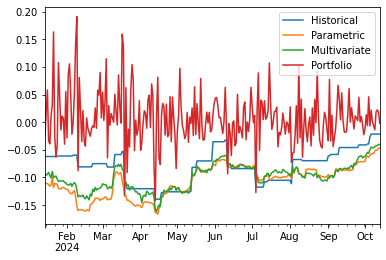

In [80]:
var_data.plot()

<AxesSubplot:>

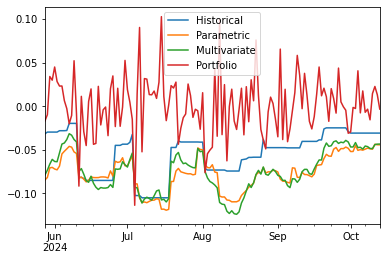

In [81]:
current_var_data.plot()

In [82]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.021898,0.007299,0.010949
Kupiec Stat,5.717926,16.221192,12.721232
P-value,0.016793,0.000056,0.000362


In [83]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.057554,0.021583,0.021583
Kupiec Stat,0.159569,2.976219,2.976219
P-value,0.689553,0.084496,0.084496


## Principal Component Analysis

### Historical PCA

In [84]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.79037921, 0.06715524, 0.05495793, 0.04519372, 0.04231391])

In [85]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014754
ADAUSDT     0.014983
ALGOUSDT    0.016525
APTUSDT     0.015911
ARBUSDT     0.016295
              ...   
WBTCUSDT    0.010389
WLDUSDT     0.022725
XLMUSDT     0.009965
XRPUSDT     0.009601
XTZUSDT     0.015108
Name: PC1, Length: 62, dtype: float64

<AxesSubplot:>

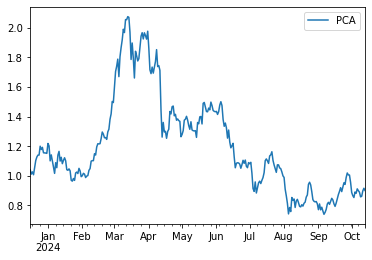

In [86]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

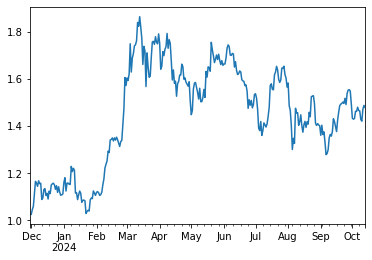

In [87]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [88]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
XTZUSDT      0.337420
ADAUSDT      0.342137
ALGOUSDT     0.349286
ETHUSDT      0.358695
               ...   
BONKUSDT     0.970304
PEPEUSDT     1.006620
FLOKIUSDT    1.011666
WLDUSDT      1.056427
OMUSDT       1.321900
Length: 63, dtype: float64

<AxesSubplot:>

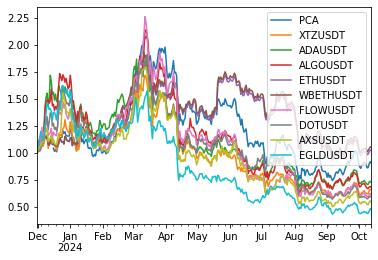

In [89]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

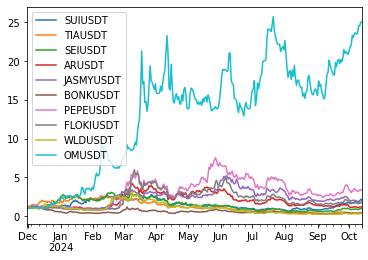

In [90]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [91]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.67288783, 0.13745704, 0.08801723, 0.06949645, 0.03214145])

In [92]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.095546
BTCUSDT      0.064864
SOLUSDT      0.104747
JASMYUSDT    0.155109
ETHUSDT      0.086680
TRXUSDT      0.014722
BBUSDT       0.242758
BNBUSDT      0.068152
PEPEUSDT     0.167421
Name: PC1, dtype: float64

<AxesSubplot:>

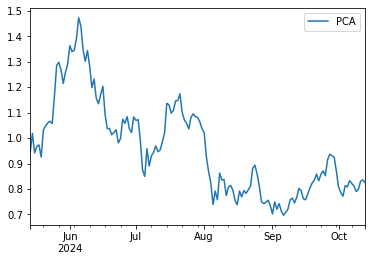

In [93]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

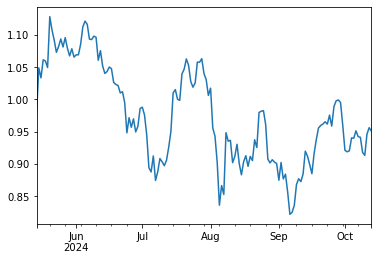

In [94]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [95]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.337687
SOLUSDT      0.346271
BTCUSDT      0.371890
BNBUSDT      0.375922
JASMYUSDT    0.428744
PEPEUSDT     0.479848
OMUSDT       0.558858
TRXUSDT      0.559863
BBUSDT       0.632975
dtype: float64

<AxesSubplot:>

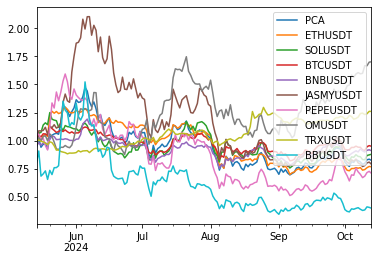

In [96]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [97]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.950044
BBUSDT       1.656254
JASMYUSDT    1.297978
SOLUSDT      1.169704
BTCUSDT      1.000000
OMUSDT       0.968094
ETHUSDT      0.955992
BNBUSDT      0.677414
TRXUSDT      0.277581
Name: BTCUSDT, dtype: float64

In [98]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.264901
PEPEUSDT     2.065206
JASMYUSDT    1.726248
SOLUSDT      1.271638
BTCUSDT      1.000000
ETHUSDT      0.991207
BNBUSDT      0.886175
OMUSDT       0.242617
TRXUSDT      0.186276
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [99]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.000000,0.150844,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.111977,0.000000,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.176594,0.000000,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451
